In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.io import loadmat
from sklearn import preprocessing

## Data setup

### 1. Data import

Data loading - the 'clean' data has datetime index 

In [2]:
data_cigre = pd.read_csv('data\Output_cigre_A1.csv')
data_cigre.index = pd.to_datetime(data_cigre.date)
data_cigre.drop(columns='date', inplace=True)

In [3]:
data_ieee = pd.read_csv('data\Output_ieee_A1.csv')
data_ieee.index = pd.to_datetime(data_ieee.date)
data_ieee.drop(columns='date', inplace=True)

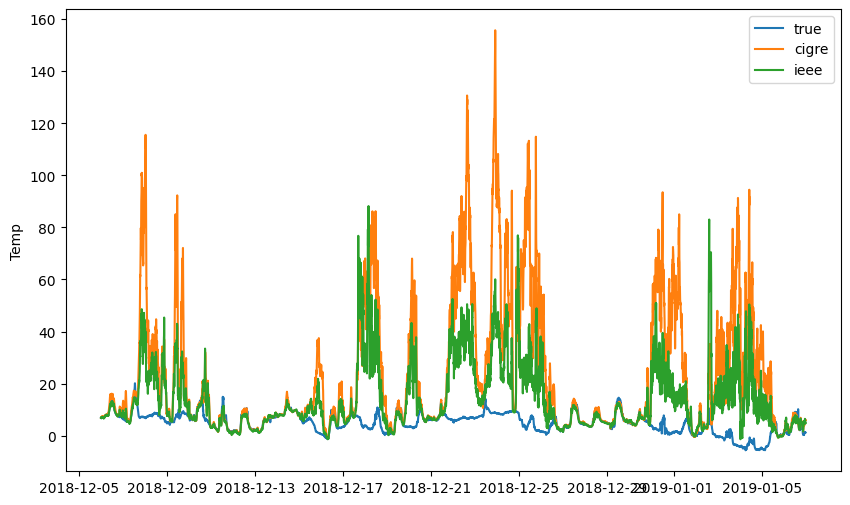

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(data_cigre.T_m_2, label='true')
plt.plot(data_cigre.T_f_2, label='cigre')
plt.plot(data_ieee.T_f_2, label='ieee')
plt.ylabel('Temp')
plt.legend()

In [5]:
data_cigre_B1 = pd.read_csv('data\Output_cigre_B1.csv')
data_cigre_B1.index = pd.to_datetime(data_cigre_B1.date, format="%d/%m/%Y %H:%M:%S")
data_cigre_B1.drop(columns='date', inplace=True)

<Axes: xlabel='date'>

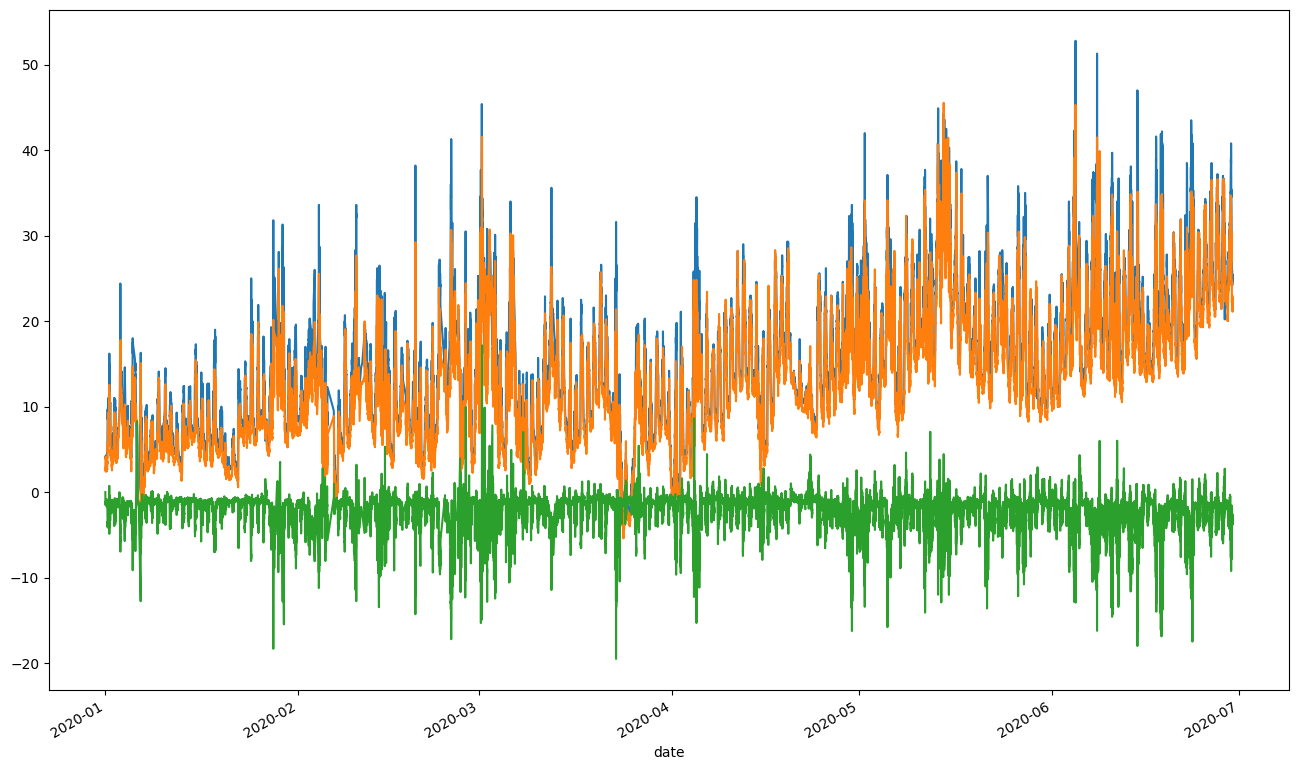

In [6]:
plt.figure(figsize=(16, 10))
data_cigre_B1['T_m'].plot()
data_cigre_B1['T_f'].plot()
data_cigre_B1['errore'].plot()

In [7]:
def check_sampling(df_1: pd.DataFrame, df_2: pd.DataFrame) -> bool:
    timedelta_1 = list(pd.Series(df_1.index).shift(-1) - pd.Series(df_1.index))[0]
    timedelta_2 = list(pd.Series(df_2.index).shift(-1) - pd.Series(df_2.index))[0]

    # If sampling of the first dataframe is sparser return true
    if timedelta_1 < timedelta_2: return True
    # Else false
    return False

In [8]:
def preprocess_csv(csv_path, date_column,  delimiter=',', freq='5min', int_method='linear'):
    
    # Read csv
    df = pd.read_csv(csv_path, delimiter=delimiter)
    date_format = '%d/%m/%Y %H:%M:%S'
        

    # Format the original df
    df.index = pd.to_datetime(df[date_column], format=date_format)
    date_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
    df.drop(columns=date_column, inplace=True)

    # Format the new df
    df_new = pd.DataFrame({date_column: date_index})
    df_new.index = df_new[date_column]
    df_new.drop(columns=date_column, inplace=True)

    # Check sampling
    if check_sampling(df, df_new):
        df.resample(freq).mean()

    # Fill the missing dates    
    df_full = df.merge(df_new, how='right', left_index=True, right_index=True)
    df_full = df_full.interpolate(method=int_method)

    X = df_full.values

    # Scale the data
    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return pd.DataFrame(data=X_scaled, columns=df_full.columns, index=date_index)

In [9]:
df = preprocess_csv('data\Output_cigre_B1.csv', 'date', freq='15min')

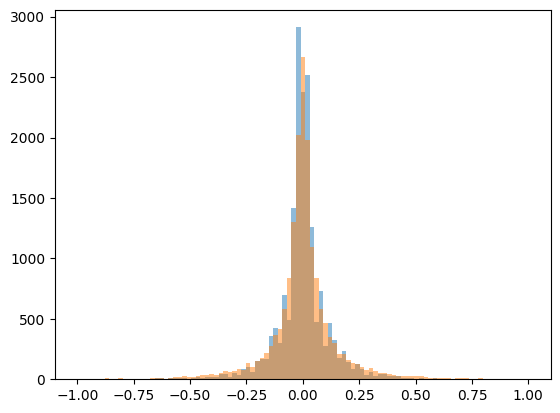

In [10]:
plt.hist(df.diff()['T_m'].values, bins=np.linspace(-1, 1, 100), alpha=0.5)
plt.hist(df.diff()['T_f'].values, bins=np.linspace(-1, 1, 100), alpha=0.5)
plt.show()

In [11]:
df.corr()

,T_f,T_m,errore
T_f,1.000000,0.973429,-0.320539
T_m,0.973429,1.000000,-0.528929
errore,-0.320539,-0.528929,1.000000


Data splits - train/val/test

<Axes: xlabel='date'>

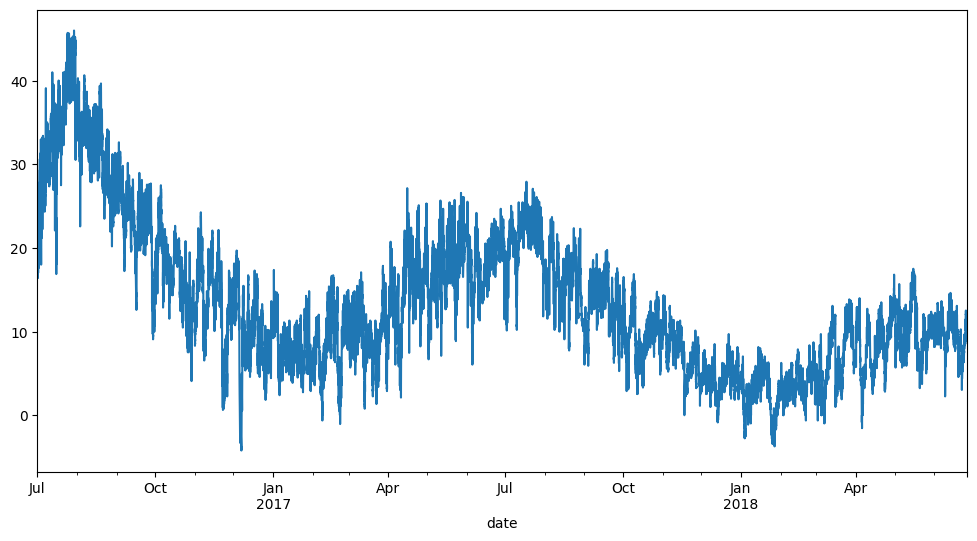

In [12]:
ett = pd.read_csv('data\ETTm1.csv', index_col=[0])
ett.index = pd.to_datetime(ett.index)
ett.OT.plot(figsize=(12, 6))

In [13]:
df_ett_1 = ett['01-01-2017':'31-05-2017'].copy()
df_ett_2 = ett['01-01-2018':'31-05-2018'].copy()
df_ohl = pd.concat([df['01-2020':'28-02-2020'], df['03-2020':'05-2020']])

print(df_ett_1.shape)
print(df_ett_2.shape)
print(df_ohl.shape)

corr_dict = {'OHL':df_ohl.T_m.values, 'ETT_1':df_ett_1.OT.values, 'ETT_2':df_ett_2.OT.values}
corr_df = pd.DataFrame(corr_dict)

(14496, 7)
(14496, 7)
(14496, 3)


### 2. Functions

In [16]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

In [17]:
def standardize(x):
    return (x - np.average(x)) / np.std(x)

In [18]:
def rolling_avg(x, n):
    return np.array([np.average(x[i-n//2:i+n//2]) for i in np.arange(n//2, len(x)-n//2)])

In [23]:
def diff(x):
    return np.array(x[1:]-np.roll(x, 1)[1:])

### Test

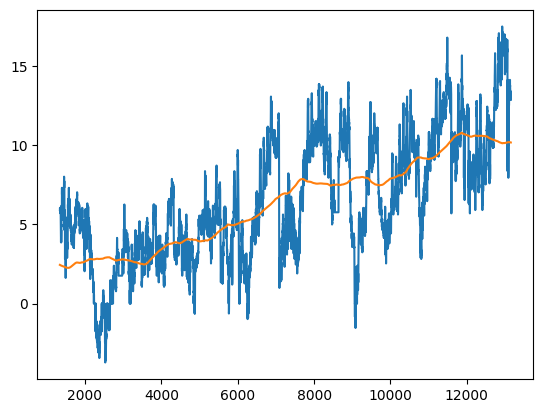

In [52]:
n = 4*24*7*4
x = np.arange(n//2, len(df_ett_2.OT.values)-n//2)
y = df_ett_2.OT.values
plt.plot(x, y[x])
plt.plot(x, rolling_avg(y, n))

y_detrended = y[x]-rolling_avg(y, n)

14495 0.00035908936878532014


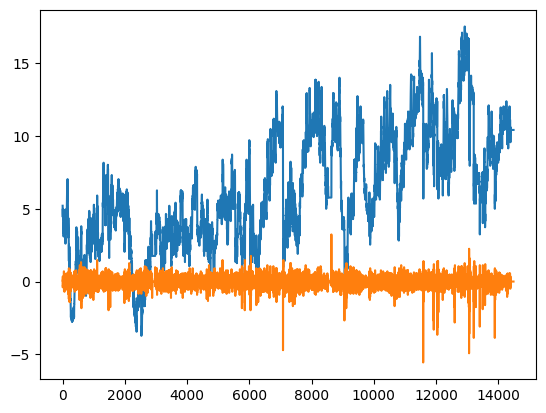

In [64]:
plt.plot(y)
plt.plot(diff(y))
# plt.plot(y[1:] + diff(y))
print(len(diff(y)), np.mean(diff(y)))

11808 0.15977675572837435
6.304538429433081


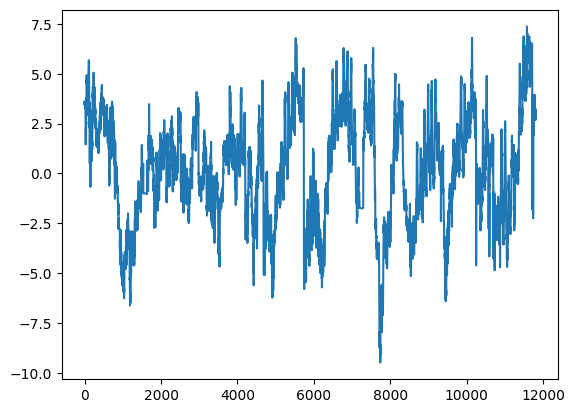

In [62]:
plt.plot(y_detrended)
print(len(y_detrended), np.average(y_detrended))
print(np.average(y))

14496 -1.552841740402868e-15


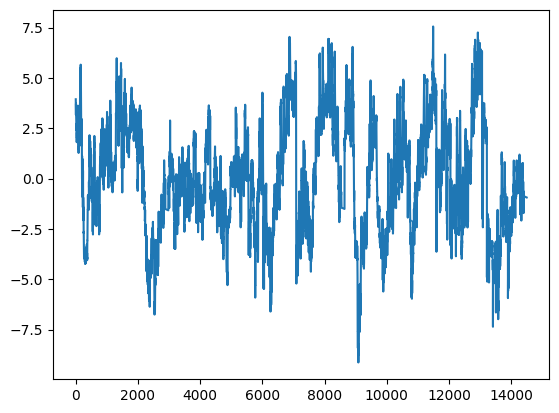

In [61]:
from scipy import signal

y_det = signal.detrend(y)
plt.plot(y_det)
print(len(y_det), np.mean(y_det))

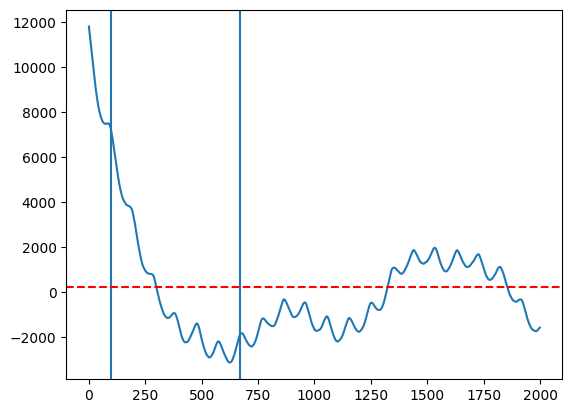

In [60]:
plt.plot(autocorr(standardize(y_detrended))[:2000])
plt.axvline(4*24)
plt.axvline(4*24*7)
plt.axhline(1.96*np.sqrt(len(y)), linestyle='--', c='r')

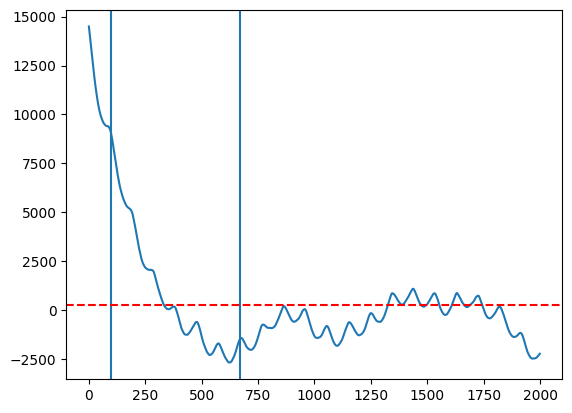

In [57]:
plt.plot(autocorr(standardize(y_det))[:2000])
plt.axvline(4*24)
plt.axvline(4*24*7)
plt.axhline(1.96*np.sqrt(len(y)), linestyle='--', c='r')

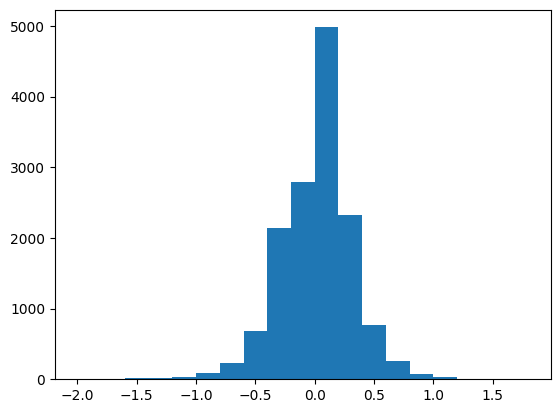

In [58]:
plt.hist(diff(y), bins=np.arange(-2, 2, 0.2))
plt.show()